## Linear scattering of a focused HIFU field by a sphere
This demo shows you how to:
* set up a focused HIFU field
* compute the acoustic field scattered by a homogeneous sphere using the volume integral equation method
* evaluate the field over a region larger than the computation region
* produce a pretty plot

In [1]:
import os
import sys
# FIXME: figure out how to avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from vines.geometry.geometry import shape, generatedomain
from vines.fields.plane_wave import PlaneWave
from vines.operators.acoustic_operators import volume_potential
from vines.precondition.threeD import circulant_embed_fftw
from vines.operators.acoustic_matvecs import mvp_vec_fftw, mvp_domain, mvp_potential_x_perm, scattered_field_3d
from scipy.sparse.linalg import LinearOperator, gmres
from vines.fields.transducers import bowl_transducer, normalise_power
from matplotlib import pyplot as plt
import matplotlib
import time

In [2]:
'''       Define transducer parameters      '''
f1 = 1.1e6              # operating/fundamental frequency
roc = 0.0632            # radius of curvature / focal length (roc)
inner_D = 0.0           # inner diameter (inner_D)
outer_D = 0.064         # outer diameter (outer_D)
power = 44              # total acoustic power (power)
focus = [roc, 0., 0.]   # focus location

In [3]:
'''      Define scatterer parameters      '''
# We consider a sphere of radius 1mm and refractive index 1.2
geom = 'sphere'
radius = 2e-3  
refInd = 1.2 + 1j * 0.0   # refractive index
scat_loc = [roc, 0., 0.]  # centre of sphere

In [4]:
'''     Define medium parameters     '''
c = 1487.0      # speed of sound
rho = 998.0     # medium density
(alpha0, eta) = (0.217, 2) # the attenuation power law info
beta = 3.5e0    # nonlinearity parameter

In [5]:
def attenuation(f, alpha0, eta):
    'Attenuation function'
    alpha = alpha0 * (f * 1e-6)**eta
    return alpha

In [6]:
# Compute useful quantities: wavelength (lam), wavenumber (k0),
# angular frequency (omega)
lam = c / f1
k1 = 2 * np.pi * f1 / c + 1j * attenuation(f1, alpha0, eta)
omega = 2 * np.pi * f1
print('Size parameter = ', np.real(k1) * radius)

Size parameter =  9.295902942700128


In [7]:
# Define the resolution of the voxel mesh - number of voxels per wavelength
# 5-10 voxels per wavelength required for reasonable accuracy
nPerLam = 5

In [8]:
# Get mesh geometry and interior wavelength
r, idx, res, P, lambda_int = shape(geom, refInd, lam, radius,
                                   nPerLam, 1)

(L, M, N) = r.shape[0:3]  # number of voxels in x-, y-, z-directions
# Shift the coordinates
r[:, :, :, 0] = r[:, :, :, 0] + scat_loc[0]

points = r.reshape(L*M*N, 3, order='F')

In [9]:
# Voxel permittivities
Mr = np.zeros((L, M, N), dtype=np.complex128)
Mr[idx] = refInd**2 - 1

In [10]:
# Assemble volume potential operator
toep = volume_potential(k1, r)
toep = k1**2 * toep

In [11]:
# Circulant embedding of volume potential operator (required for FFT-accelerated matvec)
circ_op = circulant_embed_fftw(toep, L, M, N)

In [12]:
# Define matrix-vector product and corresponding linear operator
mvp = lambda x: mvp_vec_fftw(x, circ_op, idx, Mr)
A = LinearOperator((L*M*N, L*M*N), matvec=mvp)

### Assemble right-hand side vector

In [13]:
# Generate incident field
start = time.time()
n_elements = 2**12
x, y, z, p = bowl_transducer(k1, roc, focus, outer_D / 2, n_elements,
                             inner_D / 2, points.T, 'x')
end = time.time()
print('Incident field evaluation time (s):', end-start)
dist_from_focus = np.sqrt((points[:, 0]-focus[0])**2 + points[:, 1]**2 +
                           points[:,2]**2)
idx_near = np.abs(dist_from_focus - roc) < 5e-4
p[idx_near] = 0.0

Incident field evaluation time (s): 0.9187419414520264


In [14]:
# Normalise incident field to achieve desired total acoutic power
p0 = normalise_power(power, rho, c, outer_D/2, k1, roc,
                     focus, n_elements, inner_D/2)
p *= p0
Uinc = p.reshape(L, M, N, order='F')

In [15]:
# Create array that has the incident field values in sphere, and zero outside
rhs = np.zeros((L, M, N), dtype=np.complex128)
rhs[idx] = Uinc[idx]
rhs_vec = rhs.reshape((L*M*N, 1), order='F')

### Solve linear system with iterative method (e.g., GMRES, BiCGstab)

In [16]:
# Perform iterative solve
it_count = 0

def iteration_counter(x):
    global it_count
    it_count += 1

start = time.time()
solp, info = gmres(A, rhs_vec, tol=1e-4, callback=iteration_counter)
end = time.time()
print("The linear system was solved in {0} iterations".format(it_count))
print("Solve time {0} seconds".format(end-start))

The linear system was solved in 18 iterations
Solve time 0.11893296241760254 seconds


### Postprocessing: evaluating of the total field

In [17]:
# Compute scattered and hence total field
Usca = scattered_field_3d(solp, circ_op, Mr).reshape(L, M, N, order='F')
U = Uinc + Usca

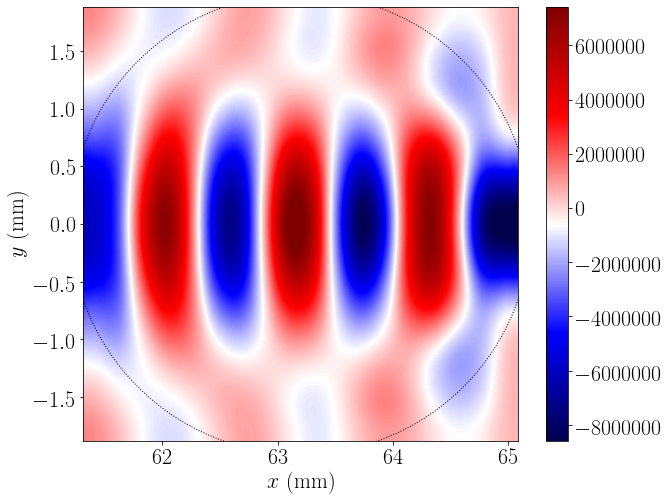

In [18]:
# Create pretty plot of field over central slice of the sphere
U_centre = U[:, :, np.int(np.round(N/2))]

matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
# Domain extremes
xmin, xmax = r[0, 0, 0, 0], r[-1, 0, 0, 0]
ymin, ymax = r[0, 0, 0, 1], r[0, -1, 0, 1]
plt.imshow(np.real(U_centre.T),
           extent=[xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'$y$ (mm)')
circle = plt.Circle((scat_loc[0]*1e3, scat_loc[1]*1e3), radius*1e3, color='black', fill=False,
                    linestyle=':')
ax.add_artist(circle)
plt.colorbar()
plt.show()

### Evaluate over a larger domain
What if we want to evaluate the field over a region that is larger than the original computation domain, which was the smallest bounding box around the hexagon? This is doable but requires the creation of a new grid and a new (Toeplitz) operator on this grid. For efficiency, it makes sense to ensure that the original grid sits within the new grid and that the pixels are the same size.

In [19]:
# First set up variables for the dimensions of bounding-box computational domain
dx = r[1, 0, 0, 0] - r[0, 0, 0, 0]
wx = r[-1, 0, 0, 0] - r[0, 0, 0, 0] + dx
wy = r[0, -1, 0, 1] - r[0, 0, 0, 1] + dx
wz = r[0, 0, -1, 2] - r[0, 0, 0, 2] + dx

In [20]:
# Create a larger domain for field evaluation
# Let's make the new domain the original one previous plus a border or width w_extra
w_extra = lam * 8
# Now adjust to make sure pixels of new ones will equal the original ones
nn = np.ceil(w_extra / dx)
wx_big = 2 * nn * dx + wx
wy_big = 2 * nn * dx + wy
wz_big = 2 * nn * dx + wz

r_big, M_big, N_big, L_big = generatedomain(dx, wx_big, wy_big, wz_big)
# Shift the coordinates
r_big[:, :, :, 0] = r_big[:, :, :, 0] + scat_loc[0]

points_big = r_big.reshape(L_big*M_big*N_big, 3, order='F')  # required for incident field evaluation

In [21]:
# Find voxels inside original computation domain
idx_eval = (r_big[:, :, :, 0] > r[0, 0, 0, 0] - dx/2) * \
        (r_big[:, :, :, 0] < r[-1, 0, 0, 0] + dx/2) * \
        (r_big[:, :, :, 1] > r[0, 0, 0, 1] - dx/2) * \
        (r_big[:, :, :, 1] < r[0, -1, 0, 1] + dx/2) * \
        (r_big[:, :, :, 2] > r[0, 0, 0, 2] - dx/2) * \
        (r_big[:, :, :, 2] < r[0, 0, -1, 2] + dx/2)

In [22]:
# Get Toeplitz operator on new domain
toep_big = volume_potential(k1, r_big)
toep_big *= k1**2
# Circulant embedding of volume potential operator (required for FFT-accelerated matvec)
circ_op_big = circulant_embed_fftw(toep_big, L_big, M_big, N_big)

In [23]:
# Voxel permittivities (refractive index matrix)
Mr_big = np.zeros((L_big, M_big, N_big), dtype=np.complex128)
Mr_big[idx_eval] = Mr.reshape(M*N*L, 1)[:, 0]

In [24]:
# Create a new solution matrix that contains the original solution at the correct locations
u_sol_big = np.zeros((M_big, N_big, L_big), dtype=np.complex128)
u_sol = solp.reshape(M, N, L, order='F')
u_sol_big[idx_eval] = u_sol.reshape(M*N*L, 1)[:, 0]

In [25]:
# Evaluate incident field on new grid
start = time.time()
n_elements = 2**12
x, y, z, p_big = bowl_transducer(k1, roc, focus, outer_D / 2, n_elements,
                             inner_D / 2, points_big.T, 'x')
end = time.time()
print('Incident field evaluation time (s):', end-start)
dist_from_focus = np.sqrt((points_big[:, 0]-focus[0])**2 + points_big[:, 1]**2 +
                           points_big[:,2]**2)
idx_near = np.abs(dist_from_focus - roc) < 5e-4
p_big[idx_near] = 0.0

Incident field evaluation time (s): 51.182729959487915


In [26]:
# Normalise incident field to achieve desired total acoutic power
p_big *= p0
Uinc_big = p_big.reshape(L_big, M_big, N_big, order='F')

In [27]:
# Convert u_sol_big into vector
solp_eval = u_sol_big.reshape((M_big*N_big*L_big, 1), order='F')
# Compute scattered and hence total field
Usca_big = scattered_field_3d(solp_eval, circ_op_big, Mr_big).reshape(L_big, M_big, N_big, order='F')

In [28]:
# Total field
U_big = Uinc_big + Usca_big

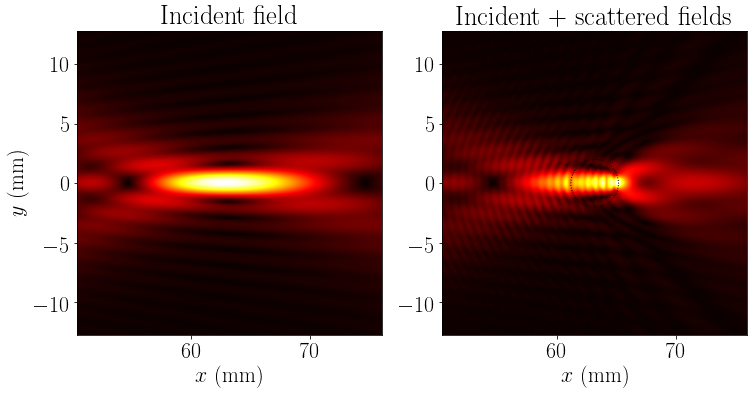

In [29]:
# Create pretty plot of field over central slice of the sphere
U_centre_big = U_big[:, :, np.int(np.round(N_big/2))]
U_centre_inc = Uinc_big[:, :, np.int(np.round(N_big/2))]

matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig = plt.figure(figsize=(12, 9))
ax = fig.gca()
# Domain extremes
xmin, xmax = r_big[0, 0, 0, 0], r_big[-1, 0, 0, 0]
ymin, ymax = r_big[0, 0, 0, 1], r_big[0, -1, 0, 1]
ax1 = plt.subplot(121)
plt.imshow(np.abs(U_centre_inc.T),
           extent=[xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3],
           cmap=plt.cm.get_cmap('hot'), interpolation='spline16')
plt.title('Incident field')
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'$y$ (mm)')

ax2 = plt.subplot(122)
plt.imshow(np.abs(U_centre_big.T),
           extent=[xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3],
           cmap=plt.cm.get_cmap('hot'), interpolation='spline16')
plt.title('Incident + scattered fields')
plt.xlabel(r'$x$ (mm)')
circle = plt.Circle((scat_loc[0]*1e3, scat_loc[1]*1e3), radius*1e3, color='black', fill=False,
                    linestyle=':')
ax2.add_artist(circle)

# # Force colorbar to be same height as plot
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)

plt.show()